# DS 542 Fall 2024 Notebook 10

The goal of this homework is to practice working with convolutional networks and modifying their architecture.

You will need to do the following with this notebook.
1. Modify the `MyNetwork` class and the call to `train_model` to achieve at least a 99% training accuracy. Partial credit will be given for progress between 96% (example given) and 99% (target).


## Module Setup

In [1]:
!pip install livelossplot --quiet
!pip install torcheval --quiet

In [2]:
import livelossplot
import matplotlib.pyplot as plt
import torch
import torcheval.metrics
import torchvision

## GPU Setup

In [3]:
def to_gpu(t):
    if torch.cuda.is_available():
        return t.cuda()
    return t

def to_numpy(t):
    return t.detach().cpu().numpy()

device = to_gpu(torch.ones(1,1)).device
device

device(type='cuda', index=0)

## Load MNIST Data Set

In [4]:
torchvision.datasets.MNIST

torchvision.datasets.mnist.MNIST

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Load the training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [8]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
train_dataset.targets.shape

torch.Size([60000])

In [10]:
# Load and prepare test data.

# YOUR CHANGES HERE

### Data Loader for Batching

In [11]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000)

In [12]:
# shenanigans to get full batch of training data after running through the dataset transform.
# iterating train_dataset only gives one row at a time.
for (train_X, train_Y) in torch.utils.data.DataLoader(train_dataset, batch_size=100000):
    break
train_Y = to_gpu(train_Y)

### Visualize a Row

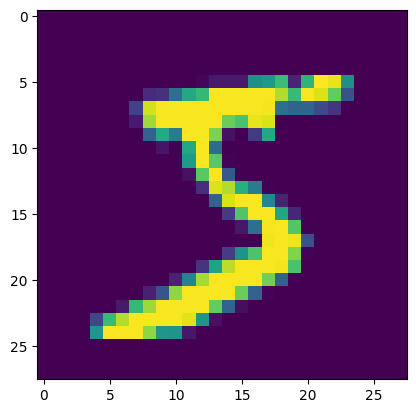

In [13]:
plt.imshow(train_dataset.data[0])

In [14]:
train_dataset.targets[0]

tensor(5)

## Configure Neural Network

In [23]:
class ExampleNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_0 = torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=2, device=device)
        self.conv_1 = torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=2, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1, device=device)
        self.fc_3 = torch.nn.Linear(160, 10)

        self.relu = torch.nn.ReLU()

    def forward(self, X):
        # first convolutional layer
        X = self.conv_0(X)
        X = self.relu(X)

        # second convolutional layer
        X = self.conv_1(X)
        X = self.relu(X)

        # third convolutional layer
        X = self.conv_2(X)
        X = self.relu(X)

        # flatten

        X = X.reshape(X.shape[:-3] + (-1,))

        # output layer is logits - no softmax
        X = self.fc_3(X)

        return X


This loss function will take in logits (softmax inputs) and target values (indices).
The PyTorch documentation says this will be more efficient than having the network output probabilities from softmax.

In [16]:
loss_function = torch.nn.CrossEntropyLoss()

## Training Loop

In [24]:
DEFAULT_EPOCHS = 1000 if torch.cuda.is_available() else 100

def train_model(model_class, epochs=DEFAULT_EPOCHS, learning_rate=1e-4, **kwargs):
    model = model_class(**kwargs)
    try:
        model = model.cuda()
    except:
        print("cuda() failed")
    model = torch.nn.DataParallel(model)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    liveloss = livelossplot.PlotLosses()
    for i in range(epochs):
        model.train()
        for (batch_X, batch_Y) in train_data_loader:

            optimizer.zero_grad(set_to_none=True)
            prediction = model(batch_X)
            loss = loss_function(prediction, to_gpu(batch_Y))
            loss.backward()
            optimizer.step()

        if (i + 1) % 2 == 0:
            # ADD TEST ACCURACY AND LOSS STATS TO CHARTS

            # YOUR CHANGES HERE
            with torch.no_grad():
                model.eval()
                prediction = model(train_X)
                loss = loss_function(prediction, train_Y)

            liveloss_updates = {
                'train_accuracy' : torcheval.metrics.functional.multiclass_accuracy(torch.argmax(prediction, dim=-1), train_Y),
                'train_loss': loss,
            }
            liveloss_updates = {k: to_numpy(v) for k, v in liveloss_updates.items()}
            liveloss.update(liveloss_updates,
                            current_step=i+1)
            liveloss.send()

    return model

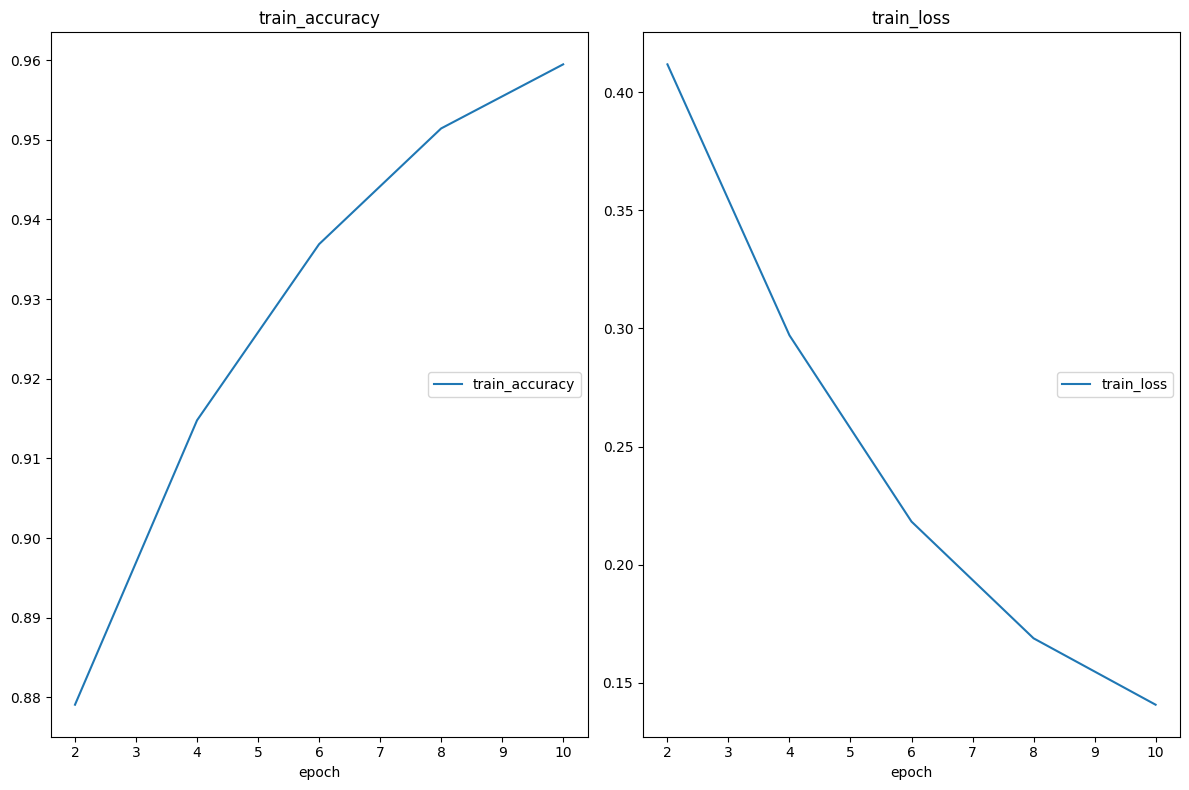

train_accuracy
	train_accuracy   	 (min:    0.879, max:    0.959, cur:    0.959)
train_loss
	train_loss       	 (min:    0.141, max:    0.412, cur:    0.141)


In [25]:
example_model = train_model(ExampleNetwork, epochs=10, learning_rate=0.001)

In [27]:
sum(p.numel() for p in example_model.parameters())

7100

In [28]:
# YOUR CHANGES HERE

class MyNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_0 = torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=2, device=device)
        self.conv_1 = torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=2, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1, device=device)
        self.fc_3 = torch.nn.Linear(160, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        # first convolutional layer
        X = self.conv_0(X)
        X = self.relu(X)

        # second convolutional layer
        X = self.conv_1(X)
        X = self.relu(X)

        # third convolutional layer
        X = self.conv_2(X)
        X = self.relu(X)

        # flatten

        X = X.reshape(X.shape[:-3] + (-1,))

        # output layer is logits - no softmax
        X = self.fc_3(X)

        return X


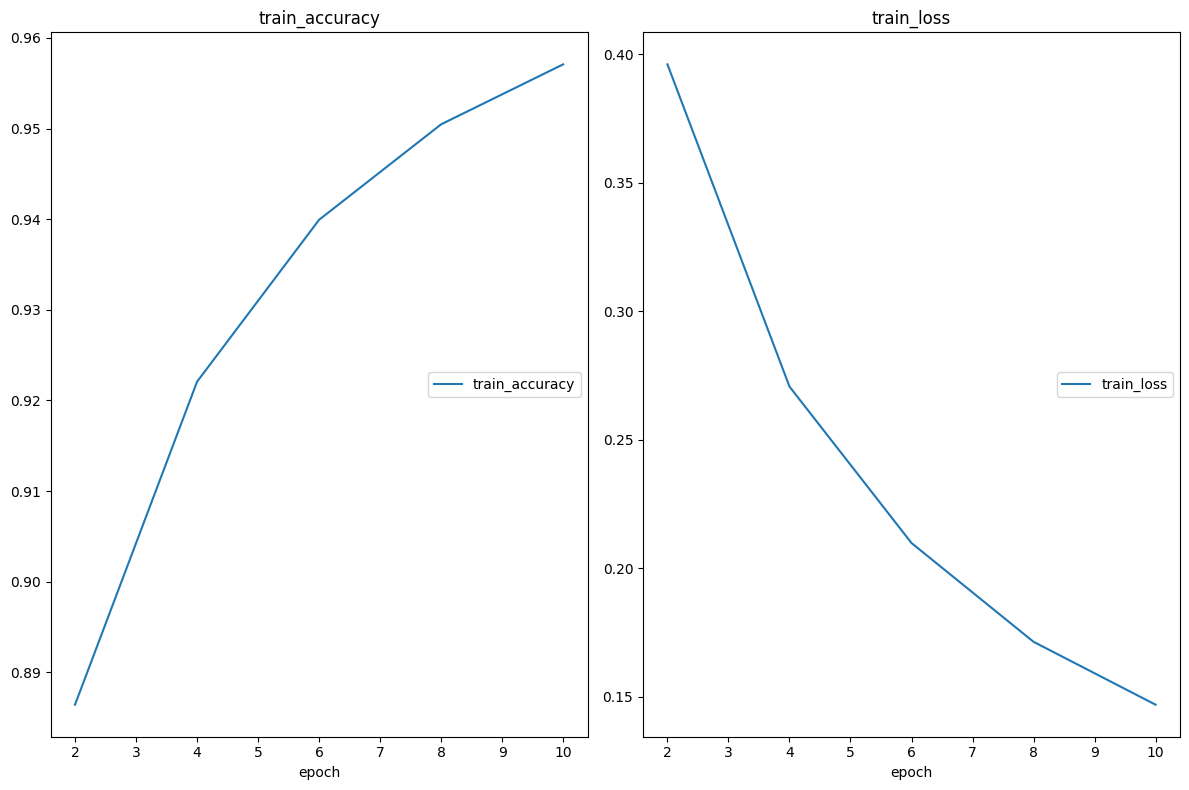

train_accuracy
	train_accuracy   	 (min:    0.886, max:    0.957, cur:    0.957)
train_loss
	train_loss       	 (min:    0.147, max:    0.396, cur:    0.147)


In [29]:
# YOUR CHANGES HERE

my_model = train_model(MyNetwork, epochs=10, learning_rate=0.001)